# MAD Mix GMM extension

To handle multivariate data and learn weights and covariance matrices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time
sys.path.insert(1, '../src/')
import madmix
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})

In [2]:
####################
####################
#   auxiliary fns  #
####################
####################
def madmix_gmm_flatten(ws,mus,Hs):
    """
    Flatten weights, meand, and logCholeskys into 2D array
    
    Inputs:
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
    
    Outpus:
        xc  : (K',B) array, flattened values
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'= K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    K,D,B=mus.shape
    
    flat_mus=mus.reshape(K*D,B)
    idx=np.tril_indices(D)
    flat_Hs=Hs[:,idx[0],idx[1],:]                     # recover lower triangular entries
    flat_Hs=flat_Hs.reshape(int(K*D*(1+0.5*(D-1))),B) # correct shape
    return np.vstack((ws,flat_mus,flat_Hs))


def madmix_gmm_unflatten(xc,K,D):
    """
    Unflatten xc into weights, meand, and covariances
    
    Inputs:
        xc  : (K',B) array, flattened values
    
    Outputs:
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'= K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    B=xc.shape[-1]
    
    # recover each flattened var
    ws=xc[:K,:]
    flat_mus=xc[K:(K*D+K),:]
    flat_Hs=xc[(K*D+K):,:].reshape(K,int(D*(1+0.5*(D-1))),B)
    
    # unflatten separately
    mus=flat_mus.reshape(K,D,B)
    Hs=np.zeros((K,D,D,B))
    idx=np.tril_indices(D)
    Hs[:,idx[0],idx[1],:]=flat_Hs
    
    return ws,mus,Hs


def HtoSigma(Hs):
    """
    Transform logCholesky factors into covariance matrices
    
    Inputs:
        Hs : (K,D,D,B) array, B observations of the K cluster logCholesky factors
        
    Outpus:
        Sigmas : (K,D,D,B) array, B observations of the K cluster covariances
    """
    
    idx=np.diag_indices(Hs.shape[1])
    Ls=np.copy(Hs)
    Ls[:,idx[0],idx[1],:]=np.exp(Hs[:,idx[0],idx[1],:])
    Ls=np.moveaxis(Ls,3,1) # so matrices are stacked in last two axes for matmul
    Sigmas=np.matmul(Ls,np.transpose(Ls,axes=(0,1,3,2)))
    return np.moveaxis(Sigmas,1,3)

def SigmatoH(Sigmas):
    """
    Transform covariance matrices into logCholesky factors
    
    Inputs:
        Sigmas : (K,D,D,B) array, B observations of the K cluster covariances
        
    Outpus:
        Hs : (K,D,D,B) array, B observations of the K cluster logCholesky factors
    """
    
    idx=np.diag_indices(Sigmas.shape[1])
    Ls=np.linalg.cholesky(np.moveaxis(Sigmas,3,1))
    Hs=np.copy(Ls)
    Hs[:,:,idx[0],idx[1]]=np.log(Ls[:,:,idx[0],idx[1]])
    return np.moveaxis(Hs,1,3)

In [3]:
ws=np.array([[0.6,0.6],[0.4,0.4]])
mus=np.zeros((2,2,2))
for b in range(2): mus[:,:,b]=np.array([[2,60],[4.5,80]])
Hs=np.zeros((2,2,2,2))
for k in range(2):
    for b in range(2):
        #Hs[k,:,:,b]=np.eye(2)
        Hs[k,:,:,b]=np.random.rand(2,2)
        Hs[k,:,:,b]=np.tril(Hs[k,:,:,b])

xc=madmix_gmm_flatten(ws,mus,Hs)

In [4]:
_,_,Hs_=madmix_gmm_unflatten(xc,2,2)
print(Hs_[0,:,:,1])

[[0.86913012 0.        ]
 [0.0416873  0.01693574]]


In [5]:
Hs[0,:,:,1]

array([[0.86913012, 0.        ],
       [0.0416873 , 0.01693574]])

In [6]:
S=HtoSigma(Hs)
print(S[0,:,:,1])

[[5.68743999 0.09941735]
 [0.09941735 1.03618947]]


In [7]:
newHs=SigmatoH(S)
print(newHs[0,:,:,1])

[[0.86913012 0.        ]
 [0.0416873  0.01693574]]


In [22]:
########################
########################
# target specification #
########################
########################
def lp(xd,xc,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    xd     : (N,B) array with labels
    #    xc     : (K',B) array with means
    #    axis   : int (0<axis<N), axis to find full conditional; if None then returns the log joint
    # outputs:
    #   ext_lprb : if axis is None, (B,) array with log joint; else, (B,K) array with d conditionals 
    N,B=xd.shape
    
    ws,mus,Hs=madmix_gmm_unflatten(xc,K,D)
    Sigmas=HtoSigma(Hs)
    
    lprbs=np.zeros((N,K,B))
    for k in range(K): 
        for b in range(B):
            lprbs[:,k,b]=stats.multivariate_normal(mus[k,:,b],Sigmas[k,:,:,b]).logpdf(y)
        # end for
    # end for
    lprbs=lprbs-aux.LogSumExp(np.moveaxis(lprbs,1,0))[:,np.newaxis,:]
    
    ext_lprb=np.zeros((N,B))
    if axis is None: 
        ext_lprb=np.zeros((N,B))
        for b in range(B): ext_lprb[:,b]=lprbs[np.arange(0,N),xd[:,b],b]
        return np.sum(ext_lprb,axis=0)
    # end if
    return lprbs[axis,:,:].T



def gen_grad_lp(xd): 
    # generate the score function for Hamiltonian dynamics
    #
    # inputs:
    #    xd     : (N,B) array with current labels
    # outputs:
    #   grad_lp : function, vectorized score function ((K',B)->(K',B))
    #
    # Note: K is the number of clusters, D is data dimension, 
    # and B is the number of data points (for vectorizing)
    # K'= K (weights) + KxD (means) + KxDxD (covariances)
    
    idx=(xd[:,None,:]==np.arange(0,K,dtype=int)[None,:,None])               #(N,K,B)
    N_pool=np.sum(idx,axis=0)                                               #(K,B)
    y_pool=np.sum(y[:,:,None,None]*idx[:,None,:,:],axis=0)/N_pool[None,:,:] #(D,K,B)
    diffs=y[:,:,None,None]-y_pool[None,:,:,:]                               #(N,D,K,B)
    S_pool=np.sum(diffs[:,:,None,:,:]*diffs[:,None,:,:,:],axis=0)           #(D,D,K,B)
    S_pool=S_pool/N_pool[None,None,:,:]                                     #(D,D,K,B)
    S_pool=np.moveaxis(S_pool,2,0)                                          #(K,D,D,B)
    S_poolT=np.transpose(S_pool,axes=(0,2,1,3)) # transpose DxD block, leave first and last axes untouched
    
    N_,D_,K_,B_= diffs.shape
    
    def mygrad_lp(xc): # in: (K',B)
        # retrieve unflattened params and invert covariance matrices
        ws,mus,Hs=madmix_gmm_unflatten(xc,K_,D_) #(K,B), (K,D,B),(K,D,D,B)
        Sigmas=HtoSigma(Hs)
        invSigmas=np.zeros((K_,D_,D_,B_))
        for k in range(K_):
            for b in range(B_):
                invSigmas[k,:,:,b]=np.linalg.inv(Sigmas[k,:,:,b])
            # end for
        # end for
        invSigmasT=np.transpose(invSigmas,axes=(0,2,1,3)) # transpose DxD block, leave first and last axes untouched
        
        # more quantities
        cluster_diffs=np.moveaxis(y_pool,1,0)-mus #(K,D,B)
        
        # calculate separate gradients
        grad_logw=N_pool/ws #(K,B)
        grads_logmu=np.zeros((K_,D_,B_))
        grads_logsigma=np.zeros((K_,D_,D_,B_))
        #for k in range(K):
        #    grads_logmu[k,:,:]=-N_pool[None,k,:]*np.sum(invSigmas[k,:,:,:]*cluster_diffs[k,None,:,:],axis=0) #(D,B)
        #    grads_logsigma[k,:,:,:]=-0.5*(1+N_pool[k,None,None,:])*invSigmasT[k,:,:,:] #(D,D,B)
        #    grads_logsigma[k,:,:,:]-=0.5*N_pool[k,None,None:]*cluster_diffs[k,:,None,:]*cluster_diffs[k,None,:,:] #(D,D,B)
        #    grads_logsigma[k,:,:,:]+=0.5*np.matmul(invSigmasT[k,:,:,:],np.matmul(S_poolT[k,:,:,:],invSigmasT[k,:,:,:])) #(D,D,B)
        # end for
        
        grads_logmu=-N_pool[k,None,:]*np.sum(invSigmas*cluster_diffs[:,None,:,:],axis=1) #(K,D,B)
        grads_logsigma=-0.5*(1+N_pool[k,None,None,:])*invSigmasT #(K,D,D,B)
        grads_logsigma-=0.5*N_pool[:,None,None:]*cluster_diffs[:,:,None,:]*cluster_diffs[:,None,:,:] #(K,D,D,B)
        print(S_poolT.shape,invSigmasT.shape)
        grads_logsigma+=0.5*np.matmul(invSigmasT,np.matmul(S_poolT,invSigmasT)) #(K,D,D,B)
        grads_logsigma+=np.diag(D-np.arange(D)+1)
        
        return madmix_gmm_flatten(grad_logw,grads_logmu,grads_logsigma) # out: (K',B)
    return mygrad_lp

### Test

In [14]:
y=dat
K=2
xd=np.random.randint(low=0,high=2,size=(y.shape[0],2))
ws_=np.array([[0.6,0.6],[0.4,0.4]])
mus_=np.zeros((2,2,2))
for b in range(2): mus_[:,:,b]=np.array([[2,60],[4.5,80]])
sigmas_=np.zeros((2,2,2,2))
for k in range(2):
    for b in range(2):
        sigmas_[k,:,:,b]=np.eye(2)

xc=madmix_gmm_flatten(ws_,mus_,sigmas_)

In [15]:
np.exp(lp(xd,xc,axis=0))

array([[2.3388671e-11, 1.0000000e+00],
       [2.3388671e-11, 1.0000000e+00]])

In [16]:
ttgrad=gen_grad_lp(xd)
tt=ttgrad(xc)
madmix_gmm_unflatten(tt,2,2)

(array([[233.33333333, 205.        ],
        [330.        , 372.5       ]]),
 array([[[ -25.7564311 ,  -30.16448078],
         [-181.57741616, -212.14190748]],
 
        [[  17.21099398,   20.5461967 ],
         [ 148.73347628,  177.28922104]]]),
 array([[[[ -151.24050533,  -147.49567282],
          [    0.        ,     0.        ]],
 
         [[ -964.21164796, -1172.42207562],
          [-6823.62424621, -8249.5906842 ]]],
 
 
        [[[  -70.68580307,   -73.70951761],
          [    0.        ,     0.        ]],
 
         [[ -526.40578409,  -667.38345638],
          [-4580.69073719, -5763.56213144]]]]))

## Old Faithful

<AxesSubplot: xlabel='eruptions', ylabel='waiting'>

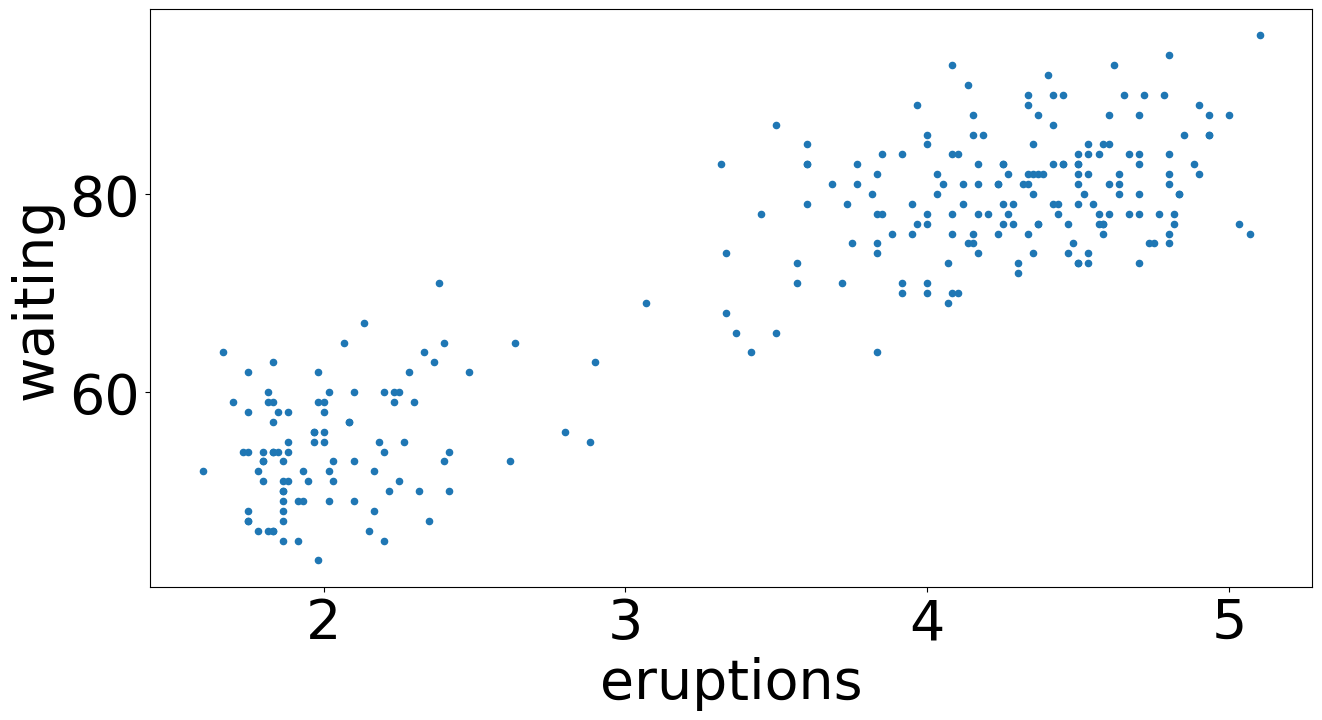

In [10]:
####################
####################
#  data wrangling  #
####################
####################
of_dat=pd.read_table('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv')
dat=np.array(of_dat)
of_dat.plot.scatter('eruptions','waiting')

In [26]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=2
steps=100
L=10
epsilon=0.01
xi=np.pi/16

# initial arrays
N,D=dat.shape
K=2
mu0=np.array([[2,50],[5,80]])
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=5.*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/5.
# end for
nu0=1.
w0=np.ones(K)/K

# reference sampler
def randq0(size):
    # discrete vars
    rxd  = np.random.randint(low=0,high=K,size=(N,size))
    rud  = np.random.rand(N,size)
    
    # continuous vars
    Kp=K+K*D+int(K*D*(1+0.5*(D-1)))
    rrho = np.random.laplace(size=(Kp,size))
    ruc  = np.random.rand(size)
    
    # weights, means, and covs separately
    rws=np.random.dirichlet(alpha=np.ones(K),size=size).T
    rmus=mu0[:,:,None]+np.sum(np.random.randn(K,D,1,size)*invsigma0[:,:,:,None],axis=2)
    rSigmas=np.zeros((K,D,D,size))
    for k in range(K): rSigmas[k,:,:,:]=np.moveaxis(stats.invwishart(int(N/K)-D-1,sigma0[k,:,:]).rvs(size=size),0,2)
    rHs=SigmatoH(rSigmas)
    rxc=madmix_gmm_flatten(rws,rmus,rHs)
    return rxd,rud,rxc,rrho,ruc

In [ ]:
xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)

(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
(2, 2, 2, 2) (2, 2, 2, 2)
